# Book 2 - Preprocessing
---

## Import Data

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from collections import Counter

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import demoji


In [117]:
# run this code if this is the first time using nltk
# import nltk
# nltk.download()

In [118]:
raw_marvel_df = pd.read_csv('./data/raw_data_marvel.csv')
raw_dc_df = pd.read_csv('./data/raw_data_dc.csv')
print(f'Marvel data shape: {raw_marvel_df.shape}')
print(f'DC data shape: {raw_dc_df.shape}')

# Join data into a single dataframe
main_df = pd.concat([raw_marvel_df,raw_dc_df],ignore_index=True)



Marvel data shape: (9993, 86)
DC data shape: (9997, 86)


C:\Users\Way Keat Koh\AppData\Local\Temp\ipykernel_12948\99939564.py:2: DtypeWarning: Columns (82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_dc_df = pd.read_csv('./data/raw_data_dc.csv')


## Data Cleaning
---
1. Remove unwanted column
2. Transform target response to binary format
3. Remove duplicates
4. Null values in 'selftext' feature is filled with empty string

In [119]:
# Remove unwanted columns
main_df = main_df[['title','selftext','subreddit','num_comments','created_utc', 'author']]

# Transform response data to binary format
main_df['subreddit'] = main_df['subreddit'].map({'DC_Cinematic':0,'marvelstudios':1})
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19990 entries, 0 to 19989
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         19990 non-null  object
 1   selftext      7764 non-null   object
 2   subreddit     19990 non-null  int64 
 3   num_comments  19990 non-null  int64 
 4   created_utc   19990 non-null  int64 
 5   author        19990 non-null  object
dtypes: int64(3), object(3)
memory usage: 937.2+ KB


In [120]:
# Check and remove for duplicates
print(f"Duplicates:\n{main_df[main_df.duplicated(['title'], keep=False)].sort_values(['title'],ascending=True)['title'].head()}\n")
duplicates = main_df[main_df.duplicated(['title'], keep=False)]
print(f"Duplicate counts:\n{duplicates['subreddit'].value_counts()}\n")
main_df = main_df.drop_duplicates(['title'],keep='first').reset_index()

# Replace null with empty text
main_df['selftext'] = main_df['selftext'].fillna('')
print(f"Sum of null: \n{main_df.isnull().sum()}")

Duplicates:
19207           "Dove of Peace" made by me on ProCreate :)
19208           "Dove of Peace" made by me on ProCreate :)
5096                         "I'm Worthy... James Worthy."
5848                         "I'm Worthy... James Worthy."
4875     "Take these, Superman. They'll help your frien...
Name: title, dtype: object

Duplicate counts:
1    655
0    553
Name: subreddit, dtype: int64

Sum of null: 
index           0
title           0
selftext        0
subreddit       0
num_comments    0
created_utc     0
author          0
dtype: int64


### Preliminary EDA
---

1. Number of unique authors are identified for each subreddit
2. 

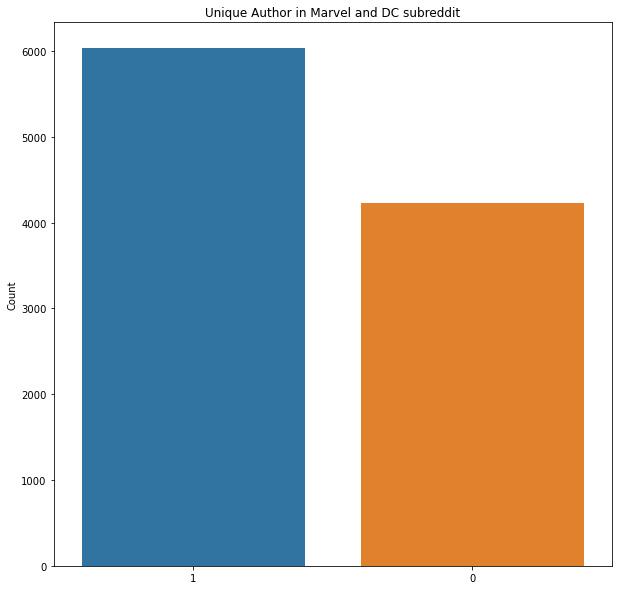

In [121]:
unique_author = pd.DataFrame(main_df.groupby('subreddit')['author'].nunique(),index=main_df['subreddit'].unique())
plt.figure(figsize=(10,10))
plt.title('Unique Author in Marvel and DC subreddit')
plt.ylabel('Count')
sns.barplot(data = unique_author.T)
plt.show();

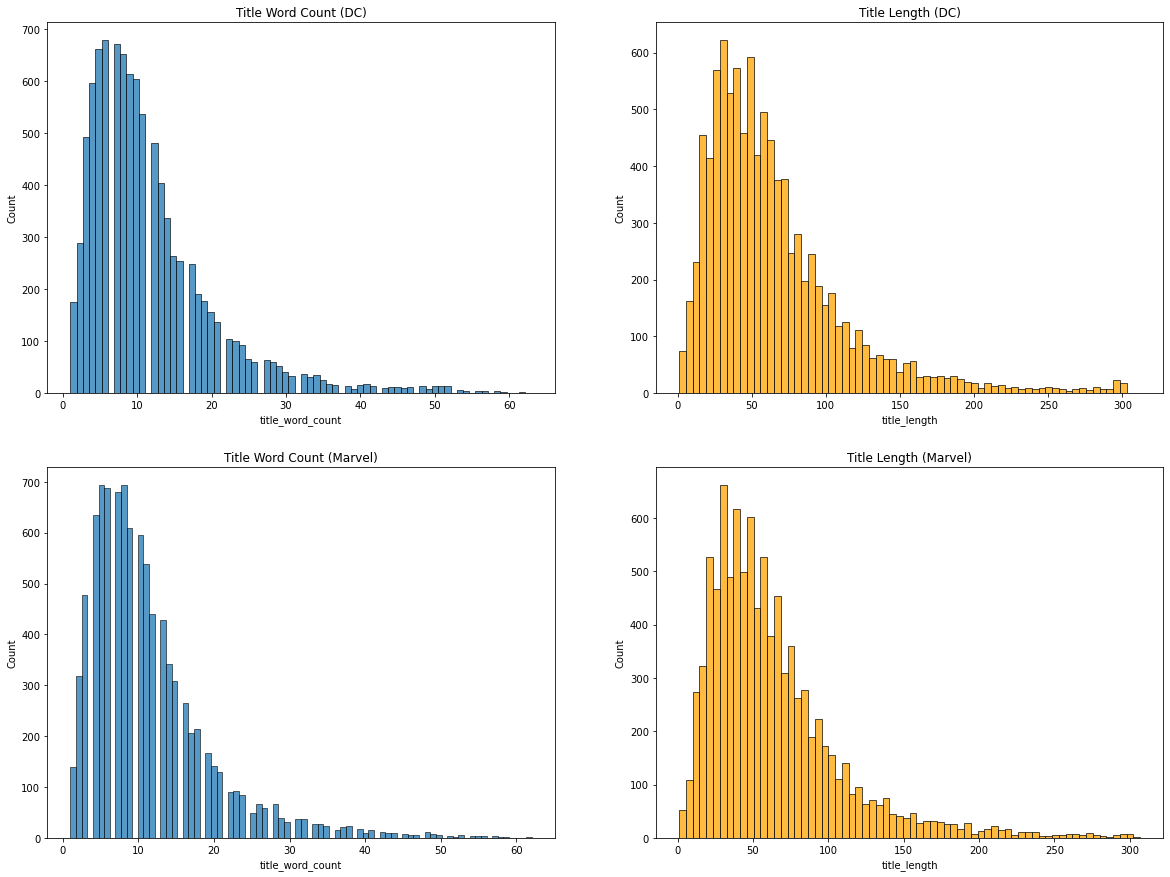

In [122]:
# Create new columns to capture word cound and length
main_df['title_word_count'] = main_df['title'].str.split().apply(len)
main_df['title_length'] = main_df['title'].apply(len)

# Display
fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].title.set_text('Title Word Count (DC)')
axs[0,1].title.set_text('Title Length (DC)')
axs[1,0].title.set_text('Title Word Count (Marvel)')
axs[1,1].title.set_text('Title Length (Marvel)')
sns.histplot(data= main_df[main_df['subreddit']==0],x='title_word_count', ax=axs[0,0])
sns.histplot(data= main_df[main_df['subreddit']==0],x='title_length',color='orange', ax=axs[0,1])
sns.histplot(data= main_df[main_df['subreddit']==1],x='title_word_count', ax=axs[1,0])
sns.histplot(data= main_df[main_df['subreddit']==1],x='title_length',color ='orange', ax=axs[1,1])
plt.show()

## Feature Engineering : "title" + "selftext" = "post"

In [123]:
# Merge title and selftext
main_df['post'] = main_df['title'] + ' ' + main_df['selftext']
print(f"Number of empty post: {len(main_df.loc[main_df['post']=='',:])}")

# Drop redundant columns
main_df = main_df.drop(columns=['title','selftext'])

Number of empty post: 0


## Tokenizing and Stemming

In [124]:
# Demojized and Tokenized data with regex
X = main_df['post']
regex_tokenizer = RegexpTokenizer('[A-Za-z]\w+')
tokens = [regex_tokenizer.tokenize(demoji.replace_with_desc(word.lower())) for word in X]

In [125]:
# De-StopWord :D
stopw = stopwords.words('english')
stopw.append('removed')
print(stopw)
no_stop_words = [[word for word in token if word not in stopw] for token in tokens]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## create column

1. without stop word 
2. without stop word and stemmed

In [126]:
stemmer = PorterStemmer()
corpus_stemmed = []
corpus_unstemmed = []
for word in no_stop_words:
    # corpus.append([stemmer.stem(item,to_lowercase=False) for item in token])
    corpus_stemmed.append(" ".join([stemmer.stem(item) for item in word]))
    corpus_unstemmed.append(" ".join([item for item in word]))

In [127]:
# Create new column to compare before and after stemmed words
main_df['post_stemmed'] = pd.DataFrame(corpus_stemmed)
main_df['post_unstemmed'] = pd.DataFrame(corpus_unstemmed)
        


In [128]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19314 entries, 0 to 19313
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             19314 non-null  int64 
 1   subreddit         19314 non-null  int64 
 2   num_comments      19314 non-null  int64 
 3   created_utc       19314 non-null  int64 
 4   author            19314 non-null  object
 5   title_word_count  19314 non-null  int64 
 6   title_length      19314 non-null  int64 
 7   post              19314 non-null  object
 8   post_stemmed      19314 non-null  object
 9   post_unstemmed    19314 non-null  object
dtypes: int64(6), object(4)
memory usage: 1.5+ MB


In [129]:
# Emoji sentiment retained
main_df.sort_values('post',ascending=False).head(100)

,index,subreddit,num_comments,created_utc,author,title_word_count,title_length,post,post_stemmed,post_unstemmed
18719,19385,0,10,1645822994,_pixel_perfect_,1,4,🧜‍♂️,merman,merman
17216,17830,0,0,1646757986,mes05,1,1,🧐,face monocl,face monocle
12220,12674,0,0,1651641585,ConfusionNo4269,1,6,🦸🏻‍♂️🐐,man superhero light skin tone goat,man superhero light skin tone goat
14733,15262,0,0,1648752406,ConfusionNo4269,1,2,🦇📸,bat camera flash,bat camera flash
12523,12991,0,0,1651257559,ConfusionNo4269,1,2,🦇🐐,bat goat,bat goat
...,...,...,...,...,...,...,...,...,...,...
2437,2505,1,0,1654706487,EUweRVis,18,114,“Instagram Reality”: This Online Community Sha...,instagram realiti onlin commun share photo peo...,instagram reality online community shares phot...
6736,6946,1,0,1653009778,bthug27,23,114,“In time you will know what it’s like to lose....,time know like lose feel desper right yet fail...,time know like lose feel desperately right yet...
15464,16026,0,0,1648136561,kivurawnuru,19,106,"“I'm just an instrument, here to unmask the tr...",instrument unmask truth cesspool call citi oc ...,instrument unmask truth cesspool call city oc ...
8115,8380,1,0,1652642096,The_chosen_one00,4,17,“I love you 3000”,love,love


In [130]:
# Drop columns with blank posts
print(f"Number of empty post in subreddit DC (before): {main_df.loc[(main_df['post_stemmed']=='')& (main_df['subreddit']==0),:].shape[0]}")
print(f"Number of empty post in subreddit Marvel (before): {main_df.loc[(main_df['post_stemmed']=='')& (main_df['subreddit']==1),:].shape[0]}\n")
main_df.loc[main_df['post_stemmed']=='',:]
main_df = main_df.drop(index=main_df.loc[main_df['post_stemmed']=='',:].index)
print(f"Number of empty post (after): {main_df[main_df['post_stemmed']==''].shape[0]}\n")

print(f"Subreddit value count after dropping blank post: \n{main_df['subreddit'].value_counts()}\n")
main_df.info()

Number of empty post in subreddit DC (before): 35
Number of empty post in subreddit Marvel (before): 29

Number of empty post (after): 0

Subreddit value count after dropping blank post: 
0    9632
1    9618
Name: subreddit, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19250 entries, 0 to 19313
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             19250 non-null  int64 
 1   subreddit         19250 non-null  int64 
 2   num_comments      19250 non-null  int64 
 3   created_utc       19250 non-null  int64 
 4   author            19250 non-null  object
 5   title_word_count  19250 non-null  int64 
 6   title_length      19250 non-null  int64 
 7   post              19250 non-null  object
 8   post_stemmed      19250 non-null  object
 9   post_unstemmed    19250 non-null  object
dtypes: int64(6), object(4)
memory usage: 1.6+ MB


## EDA 2.0
---

1. CountVectorize to split word

Text(0, 0.5, 'Word')

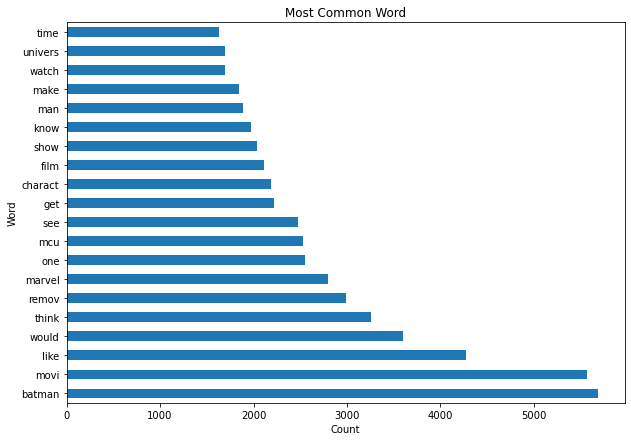

In [132]:
cvec = CountVectorizer()
cvec_data = cvec.fit_transform(main_df['post_stemmed'])
cvec_df = pd.DataFrame(cvec_data.todense(), # todense() gives a 2x2 matrix to create a dataframe
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(10,7))
cvec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Most Common Word')
plt.xlabel("Count")
plt.ylabel("Word")

Text(0, 0.5, 'Word')

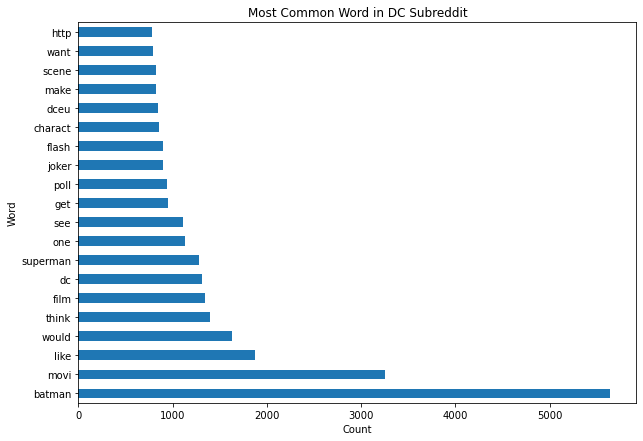

In [133]:
cvec_dc_data = cvec.fit_transform(main_df[main_df['subreddit']==0]['post_stemmed'])
cvec_dc_df = pd.DataFrame(cvec_dc_data.todense(), # todense() gives a 2x2 matrix to create a dataframe
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(10,7))
cvec_dc_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Most Common Word in DC Subreddit')
plt.xlabel("Count")
plt.ylabel("Word")

Text(0, 0.5, 'Word')

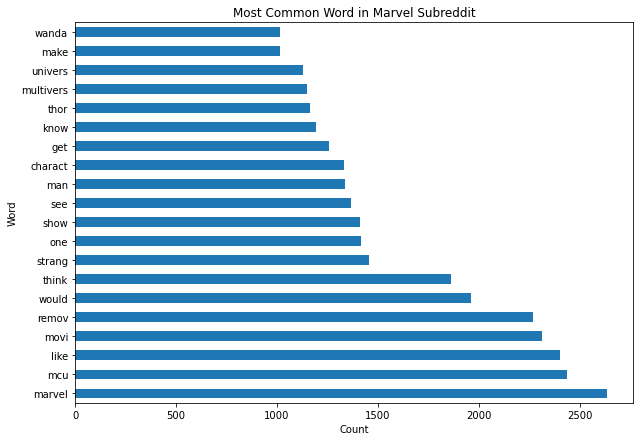

In [134]:
cvec_dc_data = cvec.fit_transform(main_df[main_df['subreddit']==1]['post_stemmed'])
cvec_dc_df = pd.DataFrame(cvec_dc_data.todense(), # todense() gives a 2x2 matrix to create a dataframe
                          columns=cvec.get_feature_names_out())
plt.figure(figsize=(10,7))
cvec_dc_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Most Common Word in Marvel Subreddit')
plt.xlabel("Count")
plt.ylabel("Word")

In [135]:
main_df[main_df['num_comments']>100].sort_values('num_comments',ascending=False)

,index,subreddit,num_comments,created_utc,author,title_word_count,title_length,post,post_stemmed,post_unstemmed
19312,19988,0,553,1645292628,acetrainer03,9,50,This is just sad. Batfleck and Cyborg were rob...,sad batfleck cyborg rob,sad batfleck cyborg robbed
18844,19511,0,460,1645706893,headphone54,3,20,Comicbook accuracy 💯,comicbook accuraci hundr point,comicbook accuracy hundred points
19216,19889,0,345,1645358261,peachy_gay,20,120,I know most people really dislike the way Warn...,know peopl realli dislik way warner handl dc a...,know people really dislike way warner handles ...
19030,19700,0,319,1645514525,harxh_s,4,20,still makes me laugh,still make laugh,still makes laugh
18656,19319,0,302,1645903668,Ao-letsgo,5,29,If only things were different,thing differ,things different
18607,19268,0,290,1645965923,kamsiuche,10,51,"it's a shame, i'm really going to miss this tr...",shame realli go miss triniti,shame really going miss trinity
19212,19884,0,278,1645363770,LiquisWasp,13,61,It’s been 15 years and I still can’t wrap my h...,year still wrap head around,years still wrap head around
19194,19866,0,253,1645379224,Alive-Ad-4164,9,53,What is your surprise predictions for the flas...,surpris predict flash movi,surprise predictions flash movie
18938,19606,0,237,1645622133,SuperAlloyBerserker,14,98,How would people think of these two psycho/soc...,would peopl think two psycho sociopath charact...,would people think two psycho sociopaths chara...
18601,19262,0,233,1645970537,Zuggy_Mcnuggy,12,89,“The batman” review embargo lifts tomorrow. Wh...,batman review embargo lift tomorrow everyon pr...,batman review embargo lifts tomorrow everyone ...


## Save data for analysis

In [136]:
pd.DataFrame.to_csv(main_df,'./data/main_data.csv',index_label=True)